In [1]:
import rebound
import time
import sys
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c

# local imports
import heartbeat
import globs
import metasim

In [2]:
read_only = True

systems = []

def run_sim(filestem='test/test',tmoons=1e3):
    
    # global variables

    globs.initialise()

    globs.glob_dclo = 1. #CE distance to check in rH
    #dir = 'test/'
    globs.glob_archive = ''
    #globals.glob_names = []
    globs.glob_is_close = False

    system = metasim.MetaSim(filestem=filestem,tmoons=tmoons)
    if not read_only:
        system.run_planets()
        if globs.glob_is_close:
            system.rewind()
            system.add_moons()
            system.run_moons()

    system.analyse()
    system.make_timeline()
    
    systems.append(system)

Simulation test/test0000



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.5230961908595093 e=0.502902542515528
Planet2 bound to EPIC220208795: a=1.180344986922353 e=0.25918404013605434
Ganymede1 bound to Planet1: a=0.007337035168043923 e=0.17136403975216613
Callisto1 bound to EPIC220208795: a=13.733965581814209 e=0.7917730476682313
Simulation test/test0001



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.3960080669467134 e=0.19497817817745552
Planet2 bound to EPIC220208795: a=2.7396254556869084 e=0.2945878187802894
Callisto1 bound to Galaxy: a=-13.175694864830719 e=10.547665277591499
Callisto2 bound to EPIC220208795: a=5.2139944159385525 e=0.906670368852637
Simulation test/test0002



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.8412457009567613 e=0.05681211466202166
Europa2 bound to Galaxy: a=-19.00410441266794 e=1.6655199484335637
Simulation test/test0003



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9668947718004856 e=0.44965196130084445
Planet2 bound to EPIC220208795: a=9.984103378732131 e=0.8259135068936593
Callisto2 bound to EPIC220208795: a=78.77639530608879 e=0.9946576814486898
Simulation test/test0004



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=12.854676022410699 e=0.8457691257647686
Planet2 bound to EPIC220208795: a=1.037684119621104 e=0.5435728445536541
Io1 bound to Planet1: a=0.003213481406908524 e=0.19284656217549379
Callisto1 bound to Galaxy: a=-6.265679847919489 e=6.784485278103186
Ganymede2 bound to Planet2: a=0.004384897877315929 e=0.08509427531890691
Simulation test/test0005



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=11.613259120590202 e=0.8304638965555443
Planet2 bound to EPIC220208795: a=1.0032599076293136 e=0.581726462907843
Io1 bound to Planet1: a=0.009054559727572475 e=0.5572806953155697
Ganymede1 bound to EPIC220208795: a=6.16123781257066 e=0.771230455233644
Callisto1 bound to EPIC220208795: a=1.4052647794895718 e=0.7073609256255616
Europa2 bound to Galaxy: a=-19.376765290391017 e=1.010634110703735
Callisto2 bound to EPIC220208795: a=507.43948737313514 e=0.9997827899416007
Simulation test/test0006



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.871166593986678 e=0.10104427098397288
Callisto1 bound to Galaxy: a=-6.88310121132742 e=6.816510977521644
Ganymede2 bound to Galaxy: a=-273.3634167010412 e=1.0546375085077053
Callisto2 bound to Galaxy: a=-93.55846884727904 e=1.6037321075412638
Simulation test/test0007



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0702551696260774 e=0.5057170515802809
Planet2 bound to EPIC220208795: a=4.975992965258493 e=0.6141632712571277
Simulation test/test0008



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.7531019552362195 e=0.059058120051460744
Europa1 bound to Galaxy: a=-15.289426633335063 e=11.78866247338128
Ganymede1 bound to EPIC220208795: a=0.8760107520350422 e=0.6379612725211079
Callisto1 bound to Galaxy: a=-52.522509936559786 e=1.020947170040978
Io2 bound to Galaxy: a=-9223.336871154455 e=1.000066219423821
Simulation test/test0009



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.1635986465035195 e=0.3852458767464925
Planet2 bound to EPIC220208795: a=1.3097131011710594 e=0.2228017093952855
Io1 bound to Planet1: a=0.0025808309967916515 e=0.20414322011148084
Ganymede1 bound to EPIC220208795: a=141.42409326675178 e=0.989488068826495
Callisto1 bound to EPIC220208795: a=25.74378746133945 e=0.9097954256639875
Europa2 bound to EPIC220208795: a=2.449960194045153 e=0.35778308255904034
Callisto2 bound to EPIC220208795: a=17.59015364295489 e=0.8763760073332187
Simulation test/test0010



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7333316550556828 e=0.12506301492246943
Ganymede1 bound to Galaxy: a=-90.21753023680894 e=1.5892486636468977
Io2 bound to Planet2: a=0.009813914449011344 e=0.5296869011402712
Simulation test/test0011



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.9399099321737998 e=0.03975419985494079
Io2 bound to EPIC220208795: a=5.666172118424107 e=0.39966423562791265
Europa2 bound to EPIC220208795: a=1.78409135856706 e=0.43775517704595673
Simulation test/test0012



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=5.684866484032115 e=0.6657126369414671
Planet2 bound to EPIC220208795: a=1.0758291279185186 e=0.4428738896920731
Europa1 bound to Galaxy: a=-3.124702833043535 e=26.717061015690074
Ganymede1 bound to EPIC220208795: a=120.27149471641204 e=0.9913281275581761
Callisto1 bound to Galaxy: a=-4.892743445576081 e=17.957279576382906
Simulation test/test0013



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.7820640450903302 e=0.403941506785327
Planet2 bound to EPIC220208795: a=1.1765947777235288 e=0.5292488713388922
Io2 bound to EPIC220208795: a=5.09952531756579 e=0.18594612447956052
Callisto2 bound to EPIC220208795: a=119.22088143237978 e=0.9826627635912656
Simulation test/test0014



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.898686667938264 e=0.065360671491673
Ganymede1 bound to Galaxy: a=-36.8783268061079 e=2.782139269285634
Callisto1 bound to EPIC220208795: a=12.088089046530262 e=0.8346553929310637
Ganymede2 bound to Galaxy: a=-125.84497198762489 e=1.780188461784902
Callisto2 bound to Galaxy: a=-80.0851713414021 e=2.1548249637463037
Simulation test/test0015



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=6.739961511654086 e=0.7273555217909684
Planet2 bound to EPIC220208795: a=1.0447096797203912 e=0.44337953730360097
Callisto1 bound to EPIC220208795: a=10.683744042245241 e=0.8868420189000732
Callisto2 bound to Galaxy: a=-11.53337302686841 e=5.836413118530344
Simulation test/test0016



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Restored from save
Planet1 bound to EPIC220208795: a=0.9281865328930793 e=0.4278921082717431
Planet2 bound to EPIC220208795: a=9.802873644366619 e=0.839042703091872
Io1 bound to Planet1: a=0.002714415334218278 e=0.14514284666638191
Europa1 bound to Planet2: a=0.005066330364742198 e=0.2343614618329893
Callisto1 bound to Galaxy: a=-14.692127319131988 e=1.3917416172956982
Io2 bound to Planet2: a=0.0027302891988252613 e=0.12906390198902543
Simulation test/test0017



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.3233209251395113 e=0.2582955395801195
Planet2 bound to EPIC220208795: a=3.0305472848281645 e=0.36226558606274106
Europa2 bound to Galaxy: a=-60.47207789039577 e=1.018742782085546
Callisto2 bound to Galaxy: a=-7.284069833227213 e=1.1142954153478162
Simulation test/test0018



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.286386379201293 e=0.2136407114088829
Planet2 bound to EPIC220208795: a=2.965688648550829 e=0.392998316611281
Ganymede1 bound to Planet1: a=0.007151520278262602 e=0.29052365347773923
Callisto1 bound to Planet1: a=0.01251942358751999 e=0.06487485126550344
Ganymede2 bound to Planet2: a=0.007081428311379781 e=0.33475231181437654
Callisto2 bound to Planet2: a=0.012790064452431197 e=0.24347697459407594
Simulation test/test0019



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0357906111280097 e=0.6703052880605278
Planet2 bound to EPIC220208795: a=6.496325737610852 e=0.6574057863660747
Io1 bound to Planet1: a=0.0027817251543618645 e=0.06351834930027256
Io2 bound to Planet2: a=0.002985606831903135 e=0.173775678011801
Simulation test/test0020



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=29.867707110626927 e=0.93885806633255
Planet2 bound to EPIC220208795: a=0.879049237112453 e=0.6855573744456008
Ganymede1 bound to Planet1: a=0.00686732771891077 e=0.4737339424182662
Callisto1 bound to Galaxy: a=-5.946313873569557 e=5.791993943249928
Io2 bound to Planet2: a=0.0032138396803293038 e=0.3884608038452579
Callisto2 bound to EPIC220208795: a=5.526542602045998 e=0.651657846200688
Simulation test/test0021



/Users/alexander/research/circumplanetary_discs/rebound/simulations/moons/metasim.py:566: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(xsize,ysize))
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7614390642285387 e=0.04474984067127734
Io1 bound to EPIC220208795: a=312.8208305998811 e=0.9899613168814951
Ganymede1 bound to Galaxy: a=-12.009661895898356 e=12.93314499155171
Io2 bound to EPIC220208795: a=1.5867958315970938 e=0.6046123973924469
Ganymede2 bound to Galaxy: a=-3.50076968294452 e=33.18810564736873
Callisto2 bound to Galaxy: a=-26.143739667158613 e=6.114365202548345
Simulation test/test0022



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8083274355219012 e=0.07074680777434891
Callisto1 bound to EPIC220208795: a=1.1577029373844265 e=0.4798215418427488
Simulation test/test0023



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8977420885120684 e=0.061527038455778574
Ganymede1 bound to Galaxy: a=-3.4241598687585286 e=46.078610145608614
Callisto1 bound to EPIC220208795: a=14.840129018515373 e=0.8931706422328392
Simulation test/test0024



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.1666432543484413 e=0.39113860113228377
Planet2 bound to EPIC220208795: a=3.5679888668138178 e=0.46572968521436775
Callisto2 bound to Galaxy: a=-224.2747286491967 e=1.0198516034752105
Simulation test/test0025



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8732839150126093 e=0.06593749923228312
Io1 bound to Planet1: a=0.008908049490261492 e=0.49468132374570606
Simulation test/test0026



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.772694291116392 e=0.4714865658245064
Planet2 bound to EPIC220208795: a=1.26882862250622 e=0.30551554755857147
Europa1 bound to Galaxy: a=-1.6675229762805661 e=45.14958884414147
Europa2 bound to EPIC220208795: a=15.256777558143819 e=0.9297098652761757
Simulation test/test0027



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9424794137252558 e=0.669106452238559
Planet2 bound to EPIC220208795: a=9.637023567559647 e=0.7927099034127243
Io1 bound to Planet1: a=0.002750729330511011 e=0.1387006870913123
Europa1 bound to Planet1: a=0.004113726832338442 e=0.13590096928187304
Io2 bound to Planet2: a=0.0028403766141743086 e=0.21087481536627703
Europa2 bound to Planet2: a=0.005352196030684833 e=0.3729580205579522
Simulation test/test0028



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.446353378808454 e=0.27713017735756323
Planet2 bound to EPIC220208795: a=1.3322589986103417 e=0.4743686782379082
Io1 bound to Galaxy: a=-45.05478491885988 e=1.1064632134354095
Io2 bound to Galaxy: a=-3.079782919323544 e=25.43207476513858
Callisto2 bound to EPIC220208795: a=62.44672700605391 e=0.9714592427034567
Simulation test/test0029

Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


ValueError: min() arg is an empty sequence

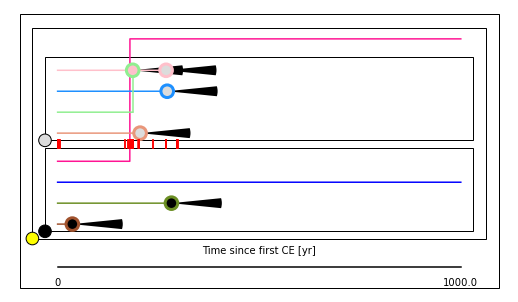

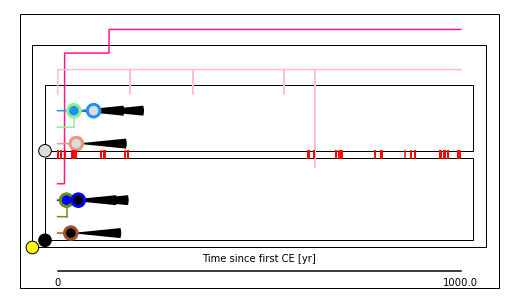

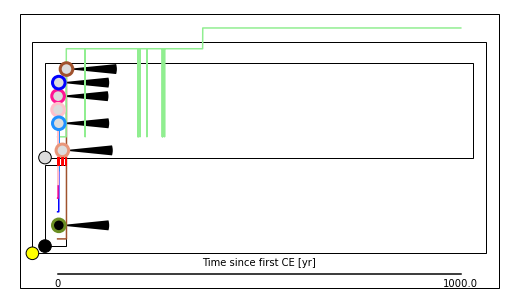

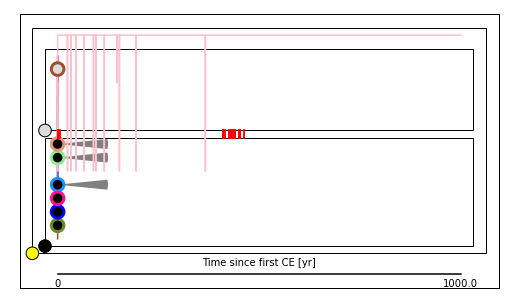

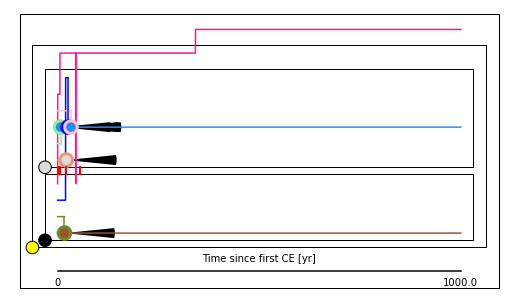

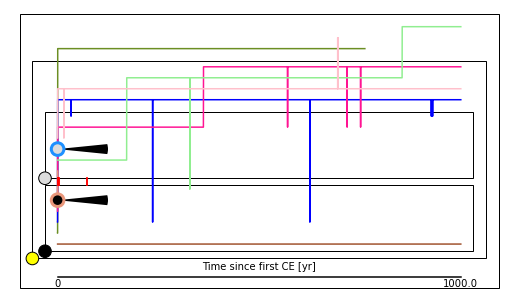

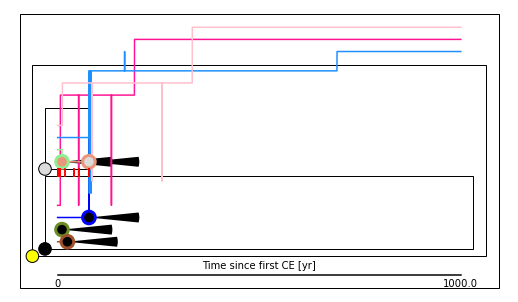

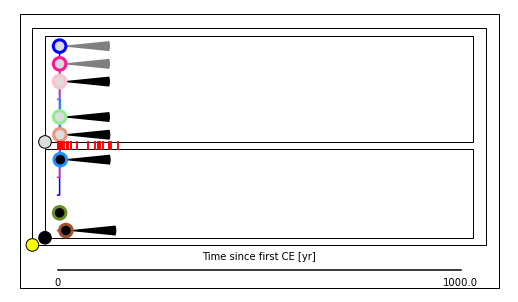

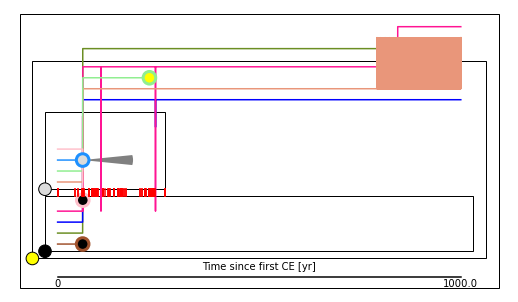

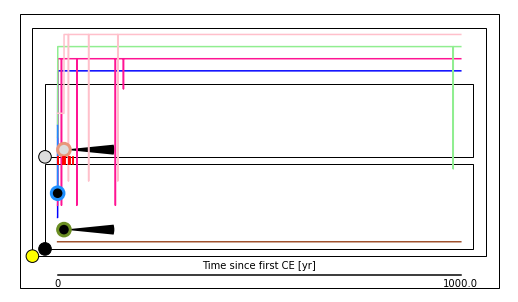

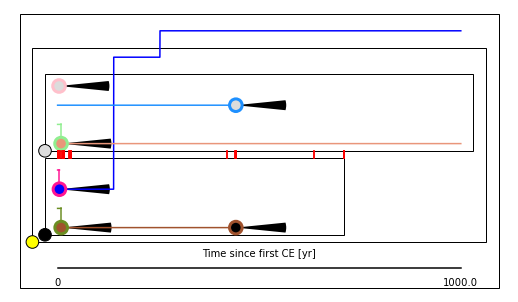

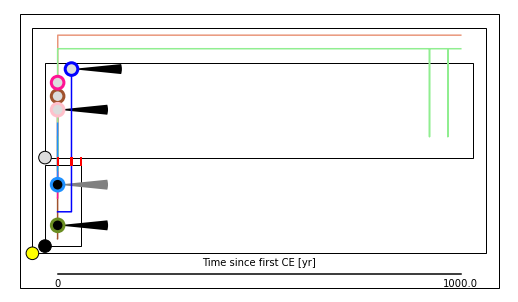

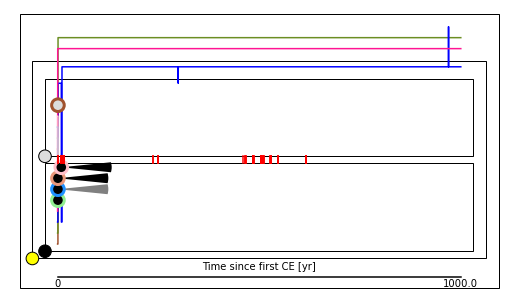

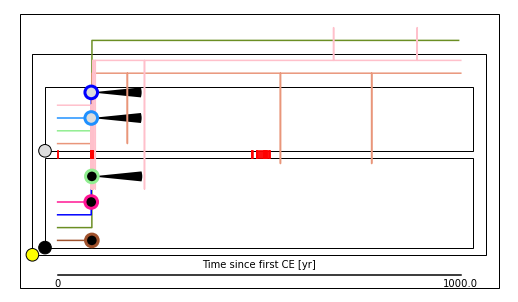

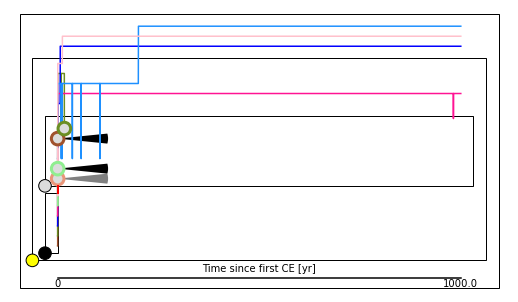

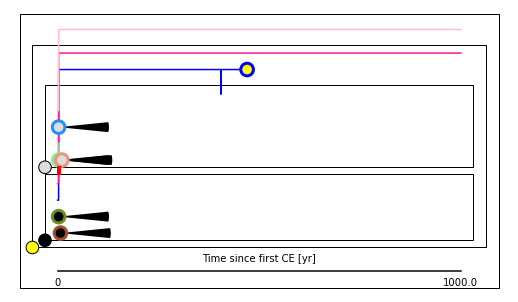

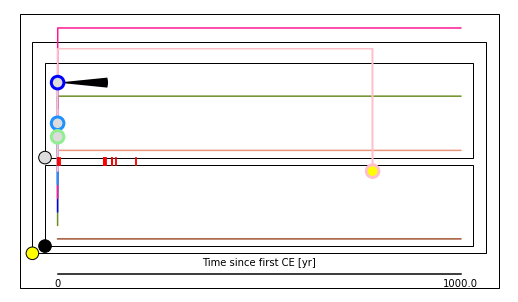

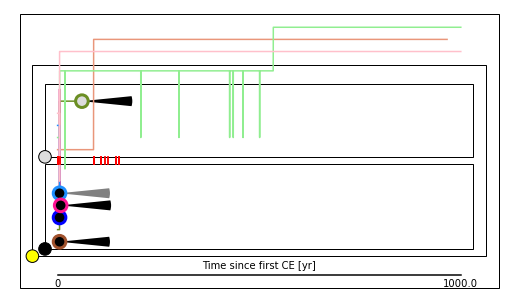

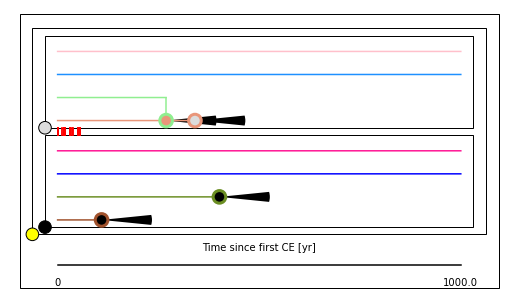

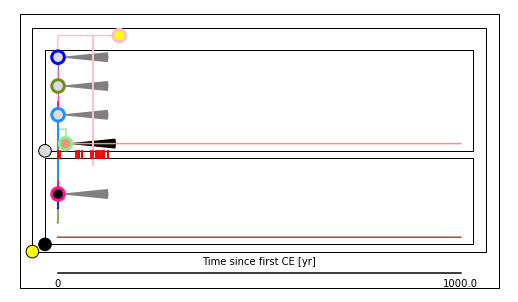

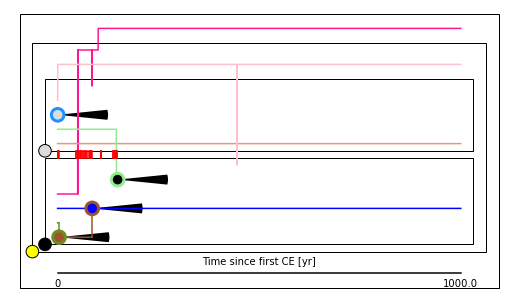

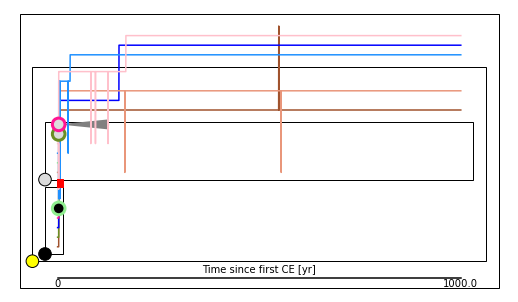

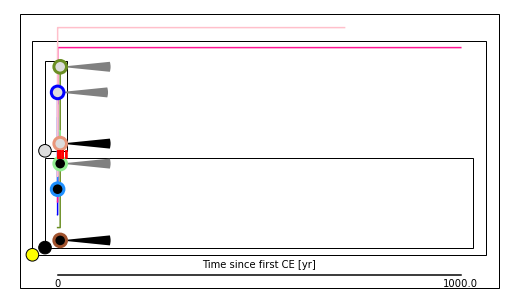

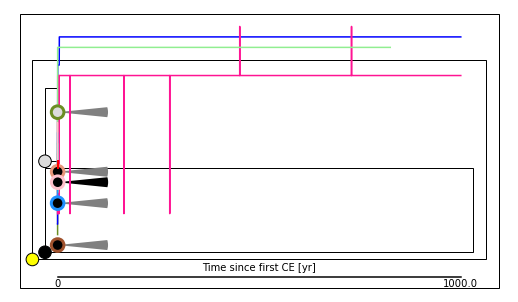

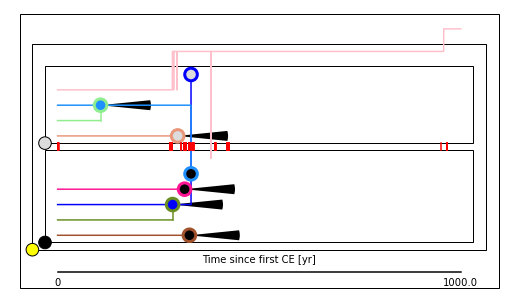

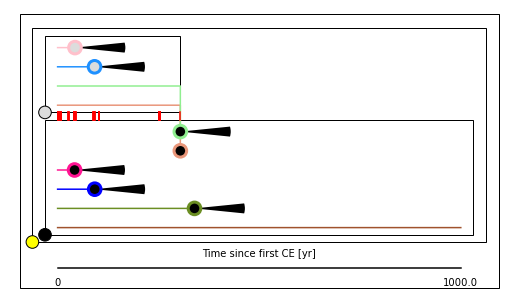

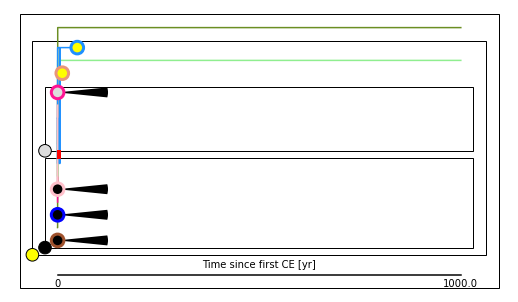

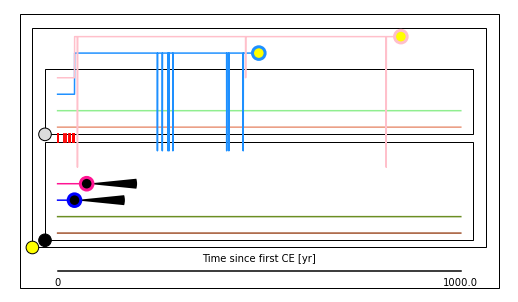

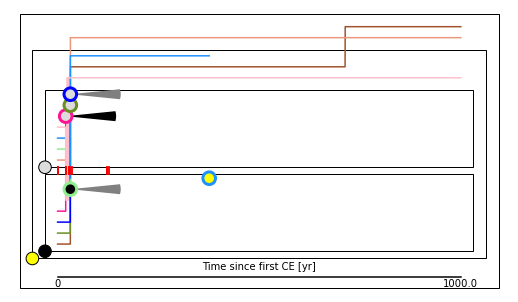

In [3]:
Nsys = 100

for i in range(Nsys):
    run_sim(filestem=f'test/test{i:04d}')
